In [2]:
'''
dev-v4_learning_erddap-python.ipynb
@author TEJ
@date 2023-02-16 thru 2023-02-23
'''
import numpy as np
import pandas as pd 
import xarray as xr
import netCDF4 as nc
import datetime as dt
from matplotlib import pyplot as plt 
import seaborn as sns
import urllib.request

import erddapClient as erd

#from erddapClient import ERDDAP_Server
#from erddapClient import ERDDAP_Tabledap

In [2]:
#defining functions from v3

def depth_profiler_area(df_pivoted,title):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df_pivoted, col ="wavelength", hue="wavelength",  palette=pal, aspect=.4, height=5)
    #g.map(sns.lineplot, "spectir", "z")
    g.map(plt.fill_between, "spectir","z")
    g.fig.suptitle(title)
    g.set_titles("")
    g.set(xticks=[], xlabel="")
    g.despine(bottom=True, left=True)
    #g.map(label, "spectir")
    #g.set(ylabel="depth (m)") #leaving this off bc it currenly labels all 7 plots.
    
def depth_profiler_line(df_pivoted,title):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    g = sns.FacetGrid(df_pivoted, col ="wavelength", hue="wavelength",  palette=pal, aspect=.4, height=5)
    g.map(sns.lineplot, "spectir", "z")
    g.fig.suptitle(title)
    g.set_titles("")
    g.set(ylabel="depth (m)")
    g.set(xlabel="")
    g.despine(left=True)
    #g.map(label, "spectir") just for now until i figure out why error

def whiskerplot_maker(df,z):
    data = []
    for i in wavelengthnm_list:
        z_list = df.query('z=={}'.format(z))[i].to_list()
        data.append(z_list)

    
    fig = plt.figure(figsize =(11, 4),dpi=150)
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

   

    plt.title("Box & Whisker plot of mean wavelengths for z = {}".format(z))
    plt.xlabel("wavelength λ")
    plt.ylabel("spectral irradiance (microW.cm^2.nm^-1)")
    ax.yaxis.grid(True)
    #set ylim according to max setwise value for visual comparison? 
    plt.ylim(-1,60)
    plt.show()

In [3]:
#defining palettes

#               black    purple     blue        cyan       green    chartreuse  orange     red
#                         412       443         490         510        555       620        683
colors_black = ["00000","#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal_black = sns.color_palette(colors_black)

colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)


colors_r = ["#ff0000", "#ff7700", "#b3ff00", "#00ff00", "#00ffff", "#001bff", "#7b00e2"]
pal_r = sns.color_palette(colors_r)

In [4]:
#defining relevant lists (for iteration)
wavelengthnm_list = ["spectir_412nm","spectir_443nm","spectir_490nm","spectir_510nm","spectir_555nm","spectir_620nm","spectir_683nm"]
wavelength_list_int = [413,443,490,510,555,620,683]
wavelength_list = ["412","443","490","510","555","620","683"]
wavelengthqc_agg_list = ["spectir_412nm_qc_agg","spectir_443nm_qc_agg","spectir_490nm_qc_agg","spectir_510nm_qc_agg","spectir_555nm_qc_agg","spectir_620nm_qc_agg","spectir_683nm_qc_agg"]
mooring_list = ["or_inshore", "or_shelf","wa_inshore","wa_shelf"]
data_id_list = ["ooi-ce01issp-sp001-07-spkirj000", "ooi-ce02shsp-sp001-06-spkirj000", 
                "ooi-ce06issp-sp001-07-spkirj000", "ooi-ce07shsp-sp001-06-spkirj000"]

In [5]:
#retrieving all data for Coastal Endurance: Oregon Inshore Surface Piercing Profiler Mooring
remote_td = erd.ERDDAP_Tabledap('http://erddap.dataexplorer.oceanobservatories.org/erddap','ooi-ce01issp-sp001-07-spkirj000')
responseDf = (
    remote_td.setResultVariables(['time','z','spectir_412nm','spectir_443nm','spectir_490nm','spectir_510nm','spectir_555nm','spectir_620nm', 'spectir_683nm'])
            .getDataFrame()
)
#eliminate units in column names
responseDf.columns = responseDf.columns.str.split(' ').str[0] 

#creating pivoted corresponding table: pivoting to make data long
responseDf_pivoted = pd.melt(responseDf, id_vars=['time', 'z'], value_vars=wavelengthnm_list,var_name='wavelength', 
                           value_name='spectir')

In [6]:
#convert time string to datetime
responseDf.time[0] #this is a string
#responseDf['time'] = pd.to_datetime(responseDf['time'], infer_datetime_format=True).astype('datetime64')
responseDf['time'] = responseDf['time'].to_numpy(dtype='datetime64')
responseDf.time[0]
#sure at least this doesn't have the time zone which pandas prefers for plotting?

Timestamp('2014-04-17 22:28:00')

In [6]:
responseDf

,time,z,spectir_412nm,spectir_443nm,spectir_490nm,spectir_510nm,spectir_555nm,spectir_620nm,spectir_683nm
0,2014-04-17T22:28:00Z,-20.0,0.030614,0.023073,0.139625,0.220813,0.442157,-0.002197,0.005706
1,2014-04-17T22:28:00Z,-19.0,0.037231,0.030066,0.171555,0.269376,0.528362,-0.000152,0.006310
2,2014-04-17T22:28:00Z,-18.0,0.048694,0.042189,0.218303,0.344181,0.669369,0.004723,0.007052
3,2014-04-17T22:28:00Z,-17.0,0.057129,0.050411,0.250974,0.395703,0.766718,0.007724,0.007074
4,2014-04-17T22:28:00Z,-16.0,0.065813,0.059395,0.283560,0.446932,0.865479,0.013464,0.007337
...,...,...,...,...,...,...,...,...,...
49938,2022-09-27T07:53:00Z,-5.0,0.010989,-0.002785,0.010997,0.007728,-0.006375,-0.005846,0.008078
49939,2022-09-27T07:53:00Z,-4.0,0.010630,-0.002738,0.010916,0.007805,-0.006242,-0.005502,0.007749
49940,2022-09-27T07:53:00Z,-3.0,0.010466,-0.002522,0.010447,0.007654,-0.007148,-0.005562,0.007265
49941,2022-09-27T07:53:00Z,-2.0,0.010201,-0.002446,0.010259,0.007780,-0.006556,-0.005270,0.006446


In [ ]:
responseDf.plot(x="time")

In [25]:
#defining test subsets of data
#a few cycles
response_small = responseDf.head(100)

#manually selected singular profile
one_pass = responseDf[46:72]

#corresponding pivoted tables. (pivoting to long form data)
small_pivoted = pd.melt(response_small, id_vars=['time', 'z'], value_vars=wavelengthnm_list,var_name='wavelength', 
                           value_name='spectir')
one_pass_pivoted = pd.melt(one_pass, id_vars=['time', 'z'], value_vars=wavelengthnm_list,var_name='wavelength', 
                           value_name='spectir')

# continuing QC endeavor from v3
what we know so far (*only for coastal enurance oregon inshore profiler*)
- qc_agg has NaN and "4" = FAIL (in every λ col), while qc_test only has NaN

In [17]:
# let's see what qc_agg vs qc_tests is.
#using different method: url request.
save_as = "qc_test_412.csv"
download_url = "http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce01issp-sp001-07-spkirj000.csv?time%2Cz%2Cspectir_412nm%2Cspectir_412nm_qc_agg%2Cspectir_412nm_qc_tests&time%3E=2022-09-24T07%3A53%3A00Z"
urllib.request.urlretrieve(download_url, save_as)

qc_df = pd.read_csv("qc_test_412.csv", dtype='unicode') 
qc_df = qc_df.drop(0)
qc_df

,time,z,spectir_412nm,spectir_412nm_qc_agg,spectir_412nm_qc_tests
1,2022-09-24T19:48:00Z,-20.0,0.0101908807,NaN,NaN
2,2022-09-24T19:49:00Z,-20.0,0.0110217111,NaN,NaN
3,2022-09-24T19:49:00Z,-19.0,0.0107561938,NaN,NaN
4,2022-09-24T19:49:00Z,-18.0,0.01015056,NaN,NaN
5,2022-09-24T19:49:00Z,-17.0,0.010153518,NaN,NaN
...,...,...,...,...,...
61,2022-09-27T07:53:00Z,-5.0,0.0109890935,NaN,NaN
62,2022-09-27T07:53:00Z,-4.0,0.0106302893,NaN,NaN
63,2022-09-27T07:53:00Z,-3.0,0.010466492,NaN,NaN
64,2022-09-27T07:53:00Z,-2.0,0.0102009981,NaN,NaN


In [63]:
print("unique values in qc_agg col:",qc_df["spectir_412nm_qc_agg"].unique())
print("unique values in qc_tests col:",qc_df["spectir_412nm_qc_tests"].unique())

unique values in qc_agg col: [nan]
unique values in qc_tests col: [nan]


In [51]:
#df that contains only QC info for the oregon inshore profiler
save_as = "qc_cols_oregon_inshore.csv"
download_url = "http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce01issp-sp001-07-spkirj000.csv?time%2Cspectir_412nm_qc_agg%2Cspectir_412nm_qc_tests%2Cspectir_443nm_qc_agg%2Cspectir_443nm_qc_tests%2Cspectir_490nm_qc_agg%2Cspectir_490nm_qc_tests%2Cspectir_510nm_qc_agg%2Cspectir_510nm_qc_tests%2Cspectir_555nm_qc_agg%2Cspectir_555nm_qc_tests%2Cspectir_620nm_qc_agg%2Cspectir_620nm_qc_tests%2Cspectir_683nm_qc_agg%2Cspectir_683nm_qc_tests"
urllib.request.urlretrieve(download_url, save_as)
qcs = pd.read_csv(save_as, dtype='unicode') 
qcs = qcs.drop(0)

In [52]:
print("unique values for the following columns: ")
print("λ         qc_agg        qc_tests")
print("412     ",qcs["spectir_412nm_qc_agg"].unique(),"   ",qcs["spectir_412nm_qc_tests"].unique())
print("443     ",qcs["spectir_443nm_qc_agg"].unique(),"   ",qcs["spectir_443nm_qc_tests"].unique())
print("490     ",qcs["spectir_490nm_qc_agg"].unique(),"   ",qcs["spectir_490nm_qc_tests"].unique())
print("510     ",qcs["spectir_510nm_qc_agg"].unique(),"   ",qcs["spectir_510nm_qc_tests"].unique())
print("555     ",qcs["spectir_555nm_qc_agg"].unique(),"   ",qcs["spectir_555nm_qc_tests"].unique())
print("620     ",qcs["spectir_620nm_qc_agg"].unique(),"   ",qcs["spectir_620nm_qc_tests"].unique())
print("683     ",qcs["spectir_683nm_qc_agg"].unique(),"   ",qcs["spectir_683nm_qc_tests"].unique())

unique values for the following columns: 
λ         qc_agg        qc_tests
412      [nan '4']     [nan]
443      [nan '4']     [nan]
490      [nan '4']     [nan]
510      [nan '4']     [nan]
555      [nan '4']     [nan]
620      [nan '4']     [nan]
683      [nan '4']     [nan]


automate this for a given df: take similar QCs dfs for all profilers

made some lists, up in lists cell initilaize

In [8]:
#dilapidated way of doing this. see cell below
for i in range(0,4):
    save_as = "qc_cols_{}.csv".format(mooring_list[i])
    download_url = "http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/{}.csv?time%2Cspectir_412nm_qc_agg%2Cspectir_412nm_qc_tests%2Cspectir_443nm_qc_agg%2Cspectir_443nm_qc_tests%2Cspectir_490nm_qc_agg%2Cspectir_490nm_qc_tests%2Cspectir_510nm_qc_agg%2Cspectir_510nm_qc_tests%2Cspectir_555nm_qc_agg%2Cspectir_555nm_qc_tests%2Cspectir_620nm_qc_agg%2Cspectir_620nm_qc_tests%2Cspectir_683nm_qc_agg%2Cspectir_683nm_qc_tests".format(data_id_list[i])
    urllib.request.urlretrieve(download_url, save_as)
    qcs = pd.read_csv(save_as, dtype='unicode') 
    qcs = qcs.drop(0)
    
    print("unique qc column values for {}:".format(mooring_list[i]))
    print("λ         qc_agg        qc_tests")
    print("412     ",qcs["spectir_412nm_qc_agg"].unique(),"   ",qcs["spectir_412nm_qc_tests"].unique())
    print("443     ",qcs["spectir_443nm_qc_agg"].unique(),"   ",qcs["spectir_443nm_qc_tests"].unique())
    print("490     ",qcs["spectir_490nm_qc_agg"].unique(),"   ",qcs["spectir_490nm_qc_tests"].unique())
    print("510     ",qcs["spectir_510nm_qc_agg"].unique(),"   ",qcs["spectir_510nm_qc_tests"].unique())
    print("555     ",qcs["spectir_555nm_qc_agg"].unique(),"   ",qcs["spectir_555nm_qc_tests"].unique())
    print("620     ",qcs["spectir_620nm_qc_agg"].unique(),"   ",qcs["spectir_620nm_qc_tests"].unique())
    print("683     ",qcs["spectir_683nm_qc_agg"].unique(),"   ",qcs["spectir_683nm_qc_tests"].unique())
    print("-----------------------------------")

unique qc column values for or_inshore:
λ         qc_agg        qc_tests
412      [nan '4']     [nan]
443      [nan '4']     [nan]
490      [nan '4']     [nan]
510      [nan '4']     [nan]
555      [nan '4']     [nan]
620      [nan '4']     [nan]
683      [nan '4']     [nan]
-----------------------------------
unique qc column values for or_shelf:
λ         qc_agg        qc_tests
412      [nan '4']     [nan]
443      [nan '4']     [nan]
490      [nan '4']     [nan]
510      [nan '4']     [nan]
555      [nan '4']     [nan]
620      [nan '4']     [nan]
683      [nan '4']     [nan]
-----------------------------------
unique qc column values for wa_inshore:
λ         qc_agg        qc_tests
412      [nan '4']     [nan]
443      [nan '4']     [nan]
490      [nan '4']     [nan]
510      [nan '4']     [nan]
555      [nan '4']     [nan]
620      [nan '4']     [nan]
683      [nan '4']     [nan]
-----------------------------------
unique qc column values for wa_shelf:
λ         qc_agg        qc_t

In [9]:
#doing this again but saving the data to a list of dfs
#querying using ERDDAP package/whatever function, so not saving to middle csvs. nice because no external data to this file.
mooring_dfs_qc = []
for i in range(0,4):
    
    remote_td = erd.ERDDAP_Tabledap('http://erddap.dataexplorer.oceanobservatories.org/erddap',data_id_list[i])
    df = (remote_td.setResultVariables(['time','z',
                                        'spectir_412nm','spectir_412nm_qc_agg','spectir_412nm_qc_tests',
                                        'spectir_443nm','spectir_443nm_qc_agg', 'spectir_443nm_qc_tests',
                                        'spectir_490nm','spectir_490nm_qc_agg', 'spectir_490nm_qc_tests',
                                        'spectir_510nm','spectir_510nm_qc_agg', 'spectir_510nm_qc_tests',
                                        'spectir_555nm','spectir_555nm_qc_agg', 'spectir_555nm_qc_tests',
                                        'spectir_620nm','spectir_620nm_qc_agg', 'spectir_620nm_qc_tests',
                                        'spectir_683nm','spectir_683nm_qc_agg', 'spectir_683nm_qc_tests']).getDataFrame()
                    )
    df.columns = df.columns.str.split(' ').str[0]
    print("unique qc column values for {}:".format(mooring_list[i]))
    print("λ         qc_agg        qc_tests")
    for j in range(len(wavelengthnm_list)):
        print(wavelength_list[j],
              "    ",df["{}_qc_agg".format(wavelengthnm_list[j])].unique(),
              "   ",df["{}_qc_tests".format(wavelengthnm_list[j])].unique()
             )

    print("-----------------------------------")
    mooring_dfs_qc.append(df)

unique qc column values for or_inshore:
λ         qc_agg        qc_tests
412      [nan  4.]     [nan]
443      [nan  4.]     [nan]
490      [nan  4.]     [nan]
510      [nan  4.]     [nan]
555      [nan  4.]     [nan]
620      [nan  4.]     [nan]
683      [nan  4.]     [nan]
-----------------------------------
unique qc column values for or_shelf:
λ         qc_agg        qc_tests
412      [nan  4.]     [nan]
443      [nan  4.]     [nan]
490      [nan  4.]     [nan]
510      [nan  4.]     [nan]
555      [nan  4.]     [nan]
620      [nan  4.]     [nan]
683      [nan  4.]     [nan]
-----------------------------------
unique qc column values for wa_inshore:
λ         qc_agg        qc_tests
412      [nan  4.]     [nan]
443      [nan  4.]     [nan]
490      [nan  4.]     [nan]
510      [nan  4.]     [nan]
555      [nan  4.]     [nan]
620      [nan  4.]     [nan]
683      [nan  4.]     [nan]
-----------------------------------
unique qc column values for wa_shelf:
λ         qc_agg        qc_t

here we can select only the agg cols.

In [12]:
#now a for loop to get rid of the test cols.
mooring_dfs_agg_only = []
for df in mooring_dfs_qc:
    df = df[["time","z",
             'spectir_412nm',"spectir_412nm_qc_agg",
             'spectir_443nm',"spectir_443nm_qc_agg",
             'spectir_490nm',"spectir_490nm_qc_agg",
             'spectir_510nm',"spectir_510nm_qc_agg",
             'spectir_555nm',"spectir_555nm_qc_agg",
             'spectir_620nm',"spectir_620nm_qc_agg",
             'spectir_683nm',"spectir_683nm_qc_agg"]]
    mooring_dfs_agg_only.append(df)

In [13]:
qcs_or_inshore = mooring_dfs_agg_only[0]
qcs_or_shelf = mooring_dfs_agg_only[1]
qcs_wa_inshore = mooring_dfs_agg_only[2]
qcs_wa_shelf = mooring_dfs_agg_only[3]

In [20]:
#counting non-NaN entries for every col in each of the 4 dfs
for j in range(4): #cycling through (length of) dfs list
    print(mooring_list[j]) #df name (referencing other list)
    for i in range(len(wavelengthqc_agg_list)): #cycling through cols
        print(wavelength_list[i],"  has ", mooring_dfs_agg_only[j][wavelengthqc_agg_list[i]].count(),
              "non-NaN entries and",(len(mooring_dfs_qc[j])-20),"NaN entries")

or_inshore
412   has  19 non-NaN entries and 49923 NaN entries
443   has  19 non-NaN entries and 49923 NaN entries
490   has  19 non-NaN entries and 49923 NaN entries
510   has  19 non-NaN entries and 49923 NaN entries
555   has  19 non-NaN entries and 49923 NaN entries
620   has  19 non-NaN entries and 49923 NaN entries
683   has  19 non-NaN entries and 49923 NaN entries
or_shelf
412   has  5 non-NaN entries and 100368 NaN entries
443   has  5 non-NaN entries and 100368 NaN entries
490   has  5 non-NaN entries and 100368 NaN entries
510   has  5 non-NaN entries and 100368 NaN entries
555   has  5 non-NaN entries and 100368 NaN entries
620   has  5 non-NaN entries and 100368 NaN entries
683   has  5 non-NaN entries and 100368 NaN entries
wa_inshore
412   has  8 non-NaN entries and 40136 NaN entries
443   has  8 non-NaN entries and 40136 NaN entries
490   has  8 non-NaN entries and 40136 NaN entries
510   has  8 non-NaN entries and 40136 NaN entries
555   has  8 non-NaN entries and 4013

In [28]:
#now lets get to the actual filtering.
#for each qc df, we want to separate into qc_agg = 4 and qc_agg = NaN
                    # by column:           AND / OR?    AND / OR?
    #could do punnet square:  AND/AND, AND/OR, OR/AND, OR/OR --> not clear whether '4' has more weight than nan
        # this doesn't matter because i have just learned that there are the same amount of non-NaN entries in each col, 
        # likely corresponding to the same indices. we will assume this, filter, and find out.
        
 #lets filter out all 4: in and out groups

In [29]:
#initializing: want one df for each profiler in each list. 2 lists of 4 dfs.
all4s_list = []
fails_lens = []
allNaNs_list = []
nans_lens = []
print("            qc_agg = 4 (FAIL)    qc_agg = NaN")
for i in range(len(mooring_dfs_agg_only)):
    
    print(mooring_list[i])
    qc412_all4 = mooring_dfs_agg_only[i][mooring_dfs_agg_only[i]['spectir_412nm_qc_agg'] == 4]
    
    qc412_allNan = mooring_dfs_agg_only[i][mooring_dfs_agg_only[i]['spectir_412nm_qc_agg'].isna()] 
    print("           ",len(qc412_all4),"                 ",len(qc412_allNan))
    fails_lens.append(len(qc412_all4))
    nans_lens.append(len(qc412_allNan))
    all4s_list.append(qc412_all4)
    allNaNs_list.append(qc412_allNan)

            qc_agg = 4 (FAIL)    qc_agg = NaN
or_inshore
            19                   49924
or_shelf
            5                   99827
wa_inshore
            8                   40148
wa_shelf
            20                   54977


In [93]:
#nc, don't do this until pivoting which we do in next cell
#now separating out list into dfs
or_inshore_fails = all4s_list[0]
or_inshore_nans = allNaNs_list[0]

or_shelf_fails = all4s_list[1]
or_shelf_nans = allNaNs_list[1]

wa_inshore_fails = all4s_list[2]
wa_inshore_nans = allNaNs_list[2]

wa_shelf_fails = all4s_list[3]
wa_shelf_nans = allNaNs_list[3]

now what kind of summary plot do we want to see these as? 

- box and whiskers average (whiskerplot_maker)

- depth plot (depth_profiler)

In [31]:
#for depth profile we need to pivot longwise all 8 dfs

fails_pivoted = []
nans_pivoted = []


for df in all4s_list:
    df = pd.melt(df, id_vars=['time', 'z'], value_vars=wavelengthnm_list,var_name='wavelength', 
                           value_name='spectir')
    fails_pivoted.append(df)
    
for df in allNaNs_list:
    df = pd.melt(df, id_vars=['time', 'z'], value_vars=wavelengthnm_list,var_name='wavelength', 
                           value_name='spectir')
    nans_pivoted.append(df)

In [32]:
or_inshore_fails = fails_pivoted[0]
or_inshore_nans = nans_pivoted[0]

or_shelf_fails = fails_pivoted[1]
or_shelf_nans = nans_pivoted[1]

wa_inshore_fails = fails_pivoted[2]
wa_inshore_nans = nans_pivoted[2]

wa_shelf_fails = fails_pivoted[3]
wa_shelf_nans = nans_pivoted[3]

In [54]:
#writing these out to csv to help processing ?
or_inshore_fails.to_csv("{}_fails.csv".format(mooring_list[0]),index=False)
or_shelf_fails.to_csv("{}_fails.csv".format(mooring_list[1]),index=False)
wa_inshore_fails.to_csv("{}_fails.csv".format(mooring_list[2]),index=False)
wa_shelf_fails.to_csv("{}_fails.csv".format(mooring_list[3]),index=False)

or_inshore_nans.to_csv("{}_nans.csv".format(mooring_list[0]),index=False)
or_shelf_nans.to_csv("{}_nans.csv".format(mooring_list[1]),index=False)
wa_inshore_nans.to_csv("{}_nans.csv".format(mooring_list[2]),index=False)
wa_shelf_nans.to_csv("{}_nans.csv".format(mooring_list[3]),index=False)

In [34]:
plt.close()

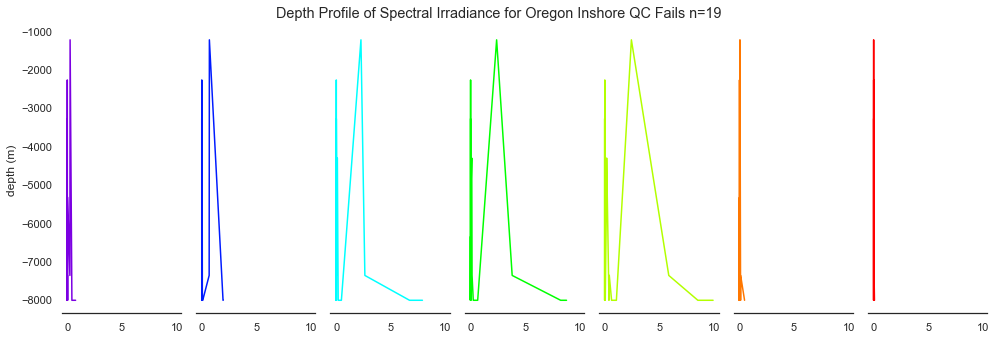

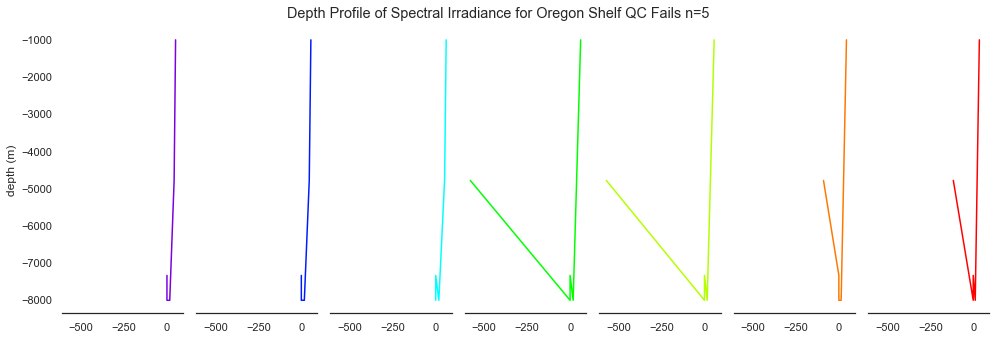

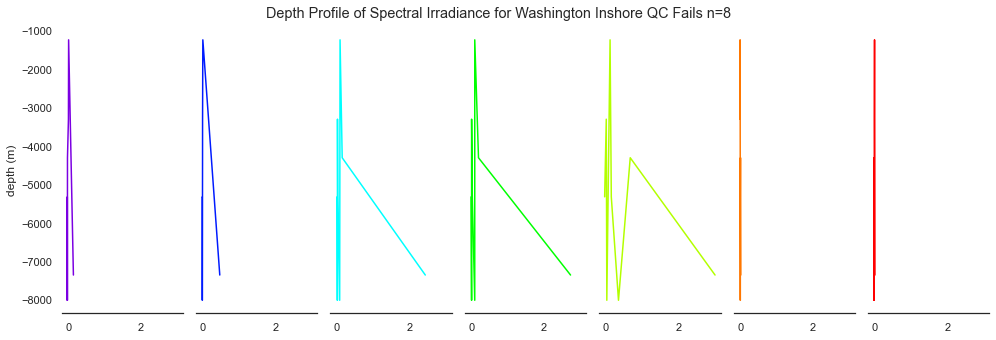

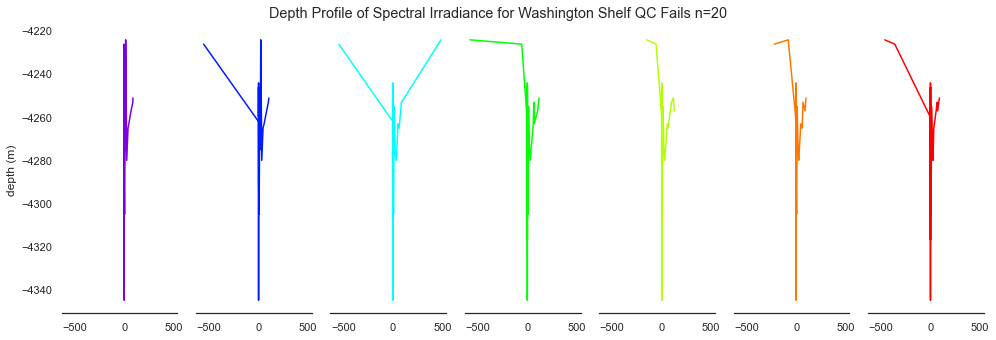

In [52]:
depth_profiler_line(or_inshore_fails,"Depth Profile of Spectral Irradiance for Oregon Inshore QC Fails n={}".format(fails_lens[0]))
depth_profiler_line(or_shelf_fails,"Depth Profile of Spectral Irradiance for Oregon Shelf QC Fails n={}".format(fails_lens[1]))
depth_profiler_line(wa_inshore_fails,"Depth Profile of Spectral Irradiance for Washington Inshore QC Fails n={}".format(fails_lens[2]))
depth_profiler_line(wa_shelf_fails,"Depth Profile of Spectral Irradiance for Washington Shelf QC Fails n={}".format(fails_lens[3]))

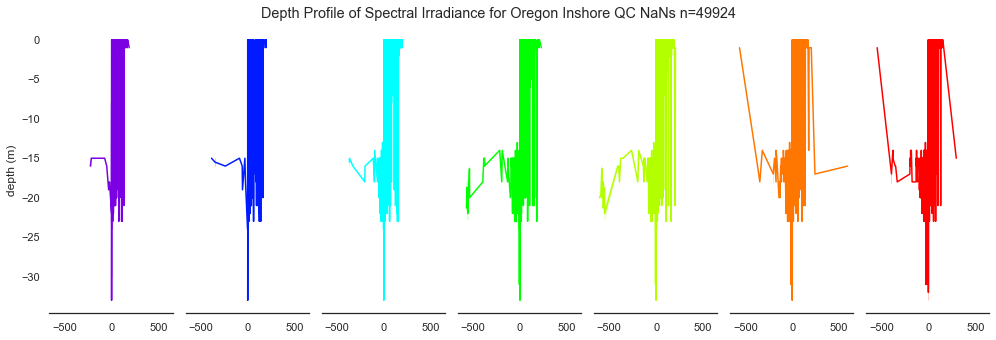

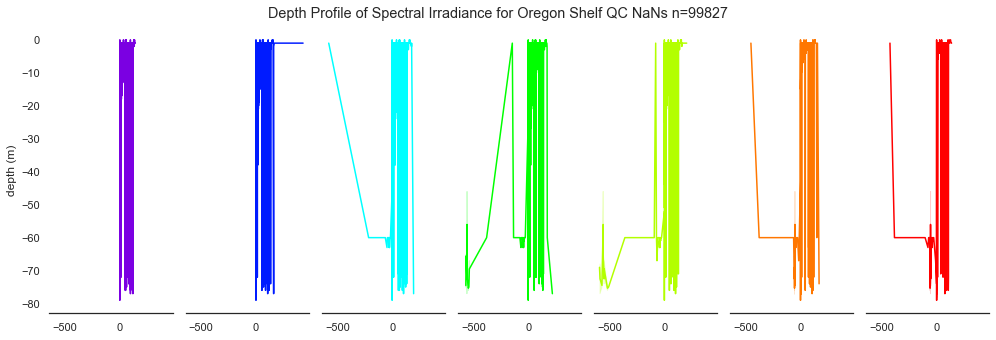

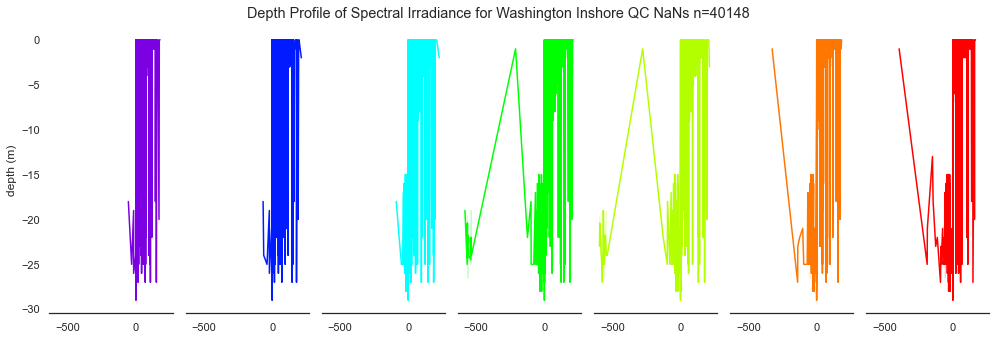

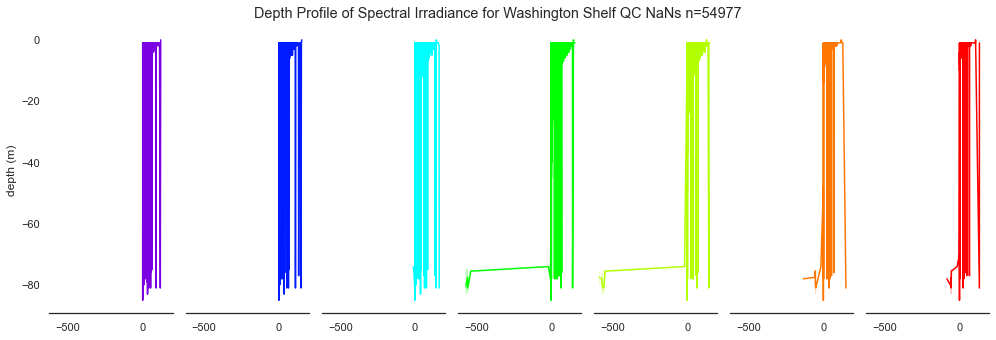

In [55]:
depth_profiler_line(or_inshore_nans,"Depth Profile of Spectral Irradiance for Oregon Inshore QC NaNs n={}".format(nans_lens[0]))
depth_profiler_line(or_shelf_nans,"Depth Profile of Spectral Irradiance for Oregon Shelf QC NaNs n={}".format(nans_lens[1]))
depth_profiler_line(wa_inshore_nans,"Depth Profile of Spectral Irradiance for Washington Inshore QC NaNs n={}".format(nans_lens[2]))
depth_profiler_line(wa_shelf_nans,"Depth Profile of Spectral Irradiance for Washington Shelf QC NaNs n={}".format(nans_lens[3]))

In [44]:
or_inshore_nans.compare(responseDf_pivoted[0:len(or_inshore_nans)])

time                           z         wavelength  \
                        self                 other  self   other       self   
8478                     NaN                   NaN -20.0 -8000.0        NaN   
8479                     NaN                   NaN -19.0   -20.0        NaN   
8480                     NaN                   NaN -18.0   -19.0        NaN   
8481                     NaN                   NaN -17.0   -18.0        NaN   
8482                     NaN                   NaN -16.0   -17.0        NaN   
...                      ...                   ...   ...     ...        ...   
349463  2022-09-27T07:53:00Z  2022-09-20T19:46:00Z  -5.0   -10.0        NaN   
349464  2022-09-27T07:53:00Z  2022-09-20T19:46:00Z  -4.0    -9.0        NaN   
349465  2022-09-27T07:53:00Z  2022-09-20T19:46:00Z  -3.0    -8.0        NaN   
349466  2022-09-27T07:53:00Z  2022-09-20T19:47:00Z  -2.0    -8.0        NaN   
349467  2022-09-27T07:53:00Z  2022-09-20T19:47:00Z  -1.0    -7.0        NaN   

               spectir            
       other      self     other  
8478     NaN -0.019139 -0.017592  
8479     NaN -0.018391 -0.019139  
8480     NaN -0.018616 -0.018391  
8481     NaN -0.018358 -0.018616  
8482     NaN -0.017845 -0.018358  
...      ...       ...       ...  
349463   NaN  0.008078  0.010496  
349464   NaN  0.007749  0.013218  
349465   NaN  0.007265  0.017591  
349466   NaN  0.006446  0.021048  
349467   NaN  0.005877  0.026991  

[340990 rows x 8 columns]

In [60]:
filtered_responseDf = responseDf[
                            (responseDf["z"] >= -33) & #condit 1
                            (responseDf["spectir_412nm"] > 0) &
                            (responseDf["spectir_443nm"] > 0) &
                            (responseDf["spectir_490nm"] > 0) &
                            (responseDf["spectir_510nm"] > 0) &
                            (responseDf["spectir_555nm"] > 0) &
                            (responseDf["spectir_620nm"] > 0) &
                            (responseDf["spectir_683nm"] > 0)].reset_index(drop=True) #condit 2 and resetting index using method

filtered_responseDf

,time,z,spectir_412nm,spectir_443nm,spectir_490nm,spectir_510nm,spectir_555nm,spectir_620nm,spectir_683nm
0,2014-04-17T22:28:00Z,-18.0,0.048694,0.042189,0.218303,0.344181,0.669369,0.004723,0.007052
1,2014-04-17T22:28:00Z,-17.0,0.057129,0.050411,0.250974,0.395703,0.766718,0.007724,0.007074
2,2014-04-17T22:28:00Z,-16.0,0.065813,0.059395,0.283560,0.446932,0.865479,0.013464,0.007337
3,2014-04-17T22:29:00Z,-16.0,0.082575,0.076288,0.342218,0.534411,1.012869,0.022377,0.007749
4,2014-04-17T22:29:00Z,-15.0,0.094298,0.088290,0.386897,0.603837,1.145983,0.029282,0.008443
...,...,...,...,...,...,...,...,...,...
25309,2022-09-24T19:50:00Z,-5.0,0.026121,0.026678,0.089246,0.408122,1.112562,1.731183,0.135638
25310,2022-09-24T19:50:00Z,-4.0,0.038530,0.045739,0.114363,0.551325,1.426770,2.738824,0.255545
25311,2022-09-24T19:50:00Z,-3.0,0.057027,0.073567,0.151391,0.737895,1.865766,4.482135,0.523181
25312,2022-09-24T19:50:00Z,-2.0,0.089921,0.114383,0.220557,0.969997,2.326666,7.342328,1.097254


In [104]:
def whiskerplot_maker(df,z,title):
    data = []
    for i in wavelengthnm_list:
        z_list = df.query('z=={}'.format(z))[i].to_list()
        data.append(z_list)
    
    fig = plt.figure(figsize =(11, 4),dpi=150)
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title+" Box and Whisker for z = {}".format(z))
    plt.xlabel("wavelength λ")
    plt.ylabel("spectral irradiance (microW.cm^2.nm^-1)")
    ax.yaxis.grid(True)
    #set ylim according to max setwise value for visual comparison? 
    #plt.ylim(-1,60)
    #plt.show()

In [76]:
depths = list(responseDf['z'].unique())
depths_filtered = list(range(-33,1))

depths_filtered.sort(reverse=True)
print(depths_filtered)

[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33]


In [100]:
# make aniamtion with https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
# and    whiskerplot_maker(df,z)

import imageio
import os


#gif_name = 

def gif_maker(df,depth_list,gif_name,title):
    filenames = []
    for i in range(len(depth_list)):
        #print(str(depths[i]))
        whiskerplot_maker(df,depth_list[i],title)

        # create file name and append it to a list
        filename = 'depth_animation{}.png'.format(str(int(depth_list[i])))
        filenames.append(filename)

        # save frame
        plt.savefig(filename,bbox_inches='tight')
        plt.close()

    # build gif
    with imageio.get_writer(gif_name, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [83]:
gif_maker(filtered_responseDf,depths_filtered,'or_inshore_whiskerplot_fixed_ax_filtered.gif', "Oregon Inshore")

In [97]:
"""or_inshore_fails=pd.read_csv("{}_fails.csv".format(mooring_list[0]))
or_shelf_fails=pd.read_csv("{}_fails.csv".format(mooring_list[1]))
wa_inshore_fails=pd.read_csv("{}_fails.csv".format(mooring_list[2]))
wa_shelf_fails=pd.read_csv("{}_fails.csv".format(mooring_list[3]))

or_inshore_nans=pd.read_csv("{}_nans.csv".format(mooring_list[0]))
or_shelf_nans=pd.read_csv("{}_nans.csv".format(mooring_list[1]))
wa_inshore_nans=pd.read_csv("{}_nans.csv".format(mooring_list[2]))
wa_shelf_nans=pd.read_csv("{}_nans.csv".format(mooring_list[3]))"""

fail_nans_df_list = [or_inshore_fails,or_shelf_fails,
                    wa_inshore_fails,wa_shelf_fails,
                    or_inshore_nans,or_shelf_nans,
                    wa_inshore_nans,wa_shelf_nans]

depths_fails_nans_list = []
for i in range(8):
    df = fail_nans_df_list[i]
    depths = list(df['z'].unique())
    depths.sort(reverse=True)
    depths_fails_nans_list.append(depths)

In [105]:
gif_maker(or_inshore_fails,depths_fails_nans_list[0],"or_inshore_fails.gif","Oregon Inshore QC Fails")
gif_maker(or_shelf_fails,depths_fails_nans_list[1],"or_shelf_fails.gif","Oregon Shelf QC Fails")
gif_maker(wa_inshore_fails,depths_fails_nans_list[2],"wa_inshore_fails.gif","Washington Inshore QC Fails")
gif_maker(wa_shelf_fails,depths_fails_nans_list[3],"wa_shelf_fails.gif","Washington Shelf QC Fails")

gif_maker(or_inshore_nans,depths_fails_nans_list[4],"or_inshore_nans.gif","Oregon Inshore QC NaNs")
gif_maker(or_shelf_nans,depths_fails_nans_list[5],"or_shelf_nans.gif","Oregon Shelf QC NaNs")
gif_maker(wa_inshore_nans,depths_fails_nans_list[6],"wa_inshore_nans.gif","Washington Inshore QC NaNs")
gif_maker(wa_shelf_nans,depths_fails_nans_list[7],"wa_shelf_nans.gif","Washington Shelf QC NaNs")


In [1]:
print(len(or_inshore_fails), "oregon inshore")

NameError: name 'or_inshore_fails' is not defined